In [29]:
from functools import partial
from ase.io import read
import zipfile
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge
from rascal.representations import SphericalInvariants as SOAP
from rascal.representations.spherical_invariants import get_power_spectrum_index_mapping
from skcosmo.preprocessing import StandardFlexibleScaler as SFS
from skcosmo.feature_selection import FPS
from skcosmo.decomposition import PCovR

In [10]:
"""Counting number of atoms from string, for the pandas Materials Project 
dataset specifically"""   
def natoms(string):
    for item in string:
        if string[(string.find('Sites'))+8] == ')':
            n=(string.find('Sites'))+7
            return int(string[n])
        else:
            n1=(string.find('Sites'))+7
            n2=(string.find('Sites'))+8
            return int(string[n1]+string[n2])

In [11]:
"""The file has been created in zip format, reading it"""

frames_init_tot=read('MP_complete_init.xyz', index=':')
frames_relax_tot=read('MP_complete_relax.xyz', index=':')

zf = zipfile.ZipFile('./MP_complete.zip') 
df_csv = pd.read_csv(zf.open('MP_complete.csv'))

natoms_list_tot=[]
for i in range(len(df_csv)):
    natoms_list_tot.append(natoms(df_csv['structure'][i]))

len(frames_init_tot), len(frames_relax_tot), len(natoms_list_tot)

KeyboardInterrupt: 

In [12]:
for frame in tqdm(frames_relax_tot):
    frame.wrap(eps=1e-10)

In [13]:
species = list(set([int(n) for frame in frames_relax_tot for n in frame.numbers]))

In [14]:
hypers = dict(
    soap_type="PowerSpectrum",
    interaction_cutoff=3.5,
    max_radial=4,
    max_angular=4,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.5,
    cutoff_smooth_width=0.5,
    global_species=species,
    expansion_by_species_method="user defined",
    normalize=False,
)
fps_soap = SOAP(
    **hypers,
)

In [15]:
idx_for_fps = np.random.randint(0, len(frames_relax_tot), 500) 
frames_for_fps = [frames_relax_tot[i] for i in idx_for_fps]

In [17]:
X_temp = np.array(
    [
        np.mean(fps_soap.transform([frame]).get_features(fps_soap), axis=0)
        for frame in tqdm(frames_for_fps)
    ]
)

THRESH = 1e-12
high_var_features = np.where(np.var(X_temp - X_temp.mean(axis=0), axis=0) > THRESH)[0]
X_temp = X_temp[:, high_var_features]

X_raw = SFS(column_wise=False).fit_transform(X_temp)
del X_temp # save on memory

n_FPS = 2000
fps = FPS(n_to_select=n_FPS, progress_bar=True).fit(X_raw)
del X_raw # save on memory

In [18]:
u_species = np.unique(species)
sp_pairs = fps_soap.get_keys(u_species)

In [20]:
coefficient_subselection = np.zeros((n_FPS, 5))
index_mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"] + 1
)

for fi, i in enumerate(high_var_features[fps.selected_idx_]):
    coefficient_subselection[fi] = [
        index_mapping[i][k] for k in ["a", "b", "n1", "n2", "l"]
    ]

In [21]:
coefficient_subselection_dict = {
    "a": coefficient_subselection[:, 0].tolist(),
    "b": coefficient_subselection[:, 1].tolist(),
    "n1": coefficient_subselection[:, 2].tolist(),
    "n2": coefficient_subselection[:, 3].tolist(),
    "l": coefficient_subselection[:, 4].tolist(),
}

soap = SOAP(**hypers, coefficient_subselection=coefficient_subselection_dict)

In [22]:
n_frames = 5000
frame_idx = np.random.randint(0, len(frames_relax_tot), n_frames)
my_frames = [frames_relax_tot[i] for i in frame_idx]

X_raw = np.zeros((len(my_frames), n_FPS))
for fi, frame in enumerate(tqdm(my_frames)):
    X_raw[fi] = np.mean(soap.transform(frame).get_features(soap), axis=0)
    
y_raw = np.array(df_csv["e_form"]).reshape(-1, 1)[frame_idx]

In [23]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X_raw.shape[0]), X_raw, y_raw, train_size=0.8
)

In [24]:
x_scaler = SFS(column_wise=False).fit(X_raw)
y_scaler = SFS(column_wise=True).fit(y_raw)

# Center total dataset
X = x_scaler.transform(X_raw)
Y = y_scaler.transform(y_raw)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [25]:
alphas=np.logspace(-0, -6, 30)

R^2 of training is  0.9415157272009358
R^2 of testing is  0.8775284220847568
Best regularization is  0.035622478902624426


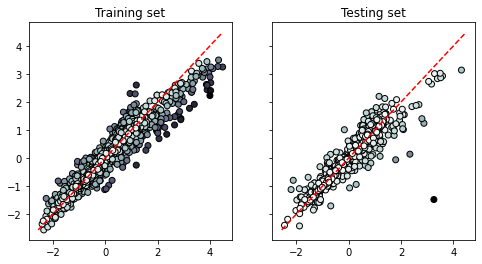

In [26]:
ridge = RidgeCV(cv=2, fit_intercept=False, alphas=alphas)
ridge.fit(X_train, y_train)
yp_test = ridge.predict(X_test)
yp_train = ridge.predict(X_train)
print("R^2 of training is ", ridge.score(X_train, y_train))
print("R^2 of testing is ", ridge.score(X_test, y_test))
print("Best regularization is ", ridge.alpha_)
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax_train.scatter(y_train, yp_train, c=np.abs(y_train - yp_train), cmap="bone_r", ec="k")
ax_test.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", ec="k")

bounds = (
    np.min((Y.min(), yp_train.min(), yp_test.min())),
    np.max((Y.max(), yp_train.max(), yp_test.max())),
)

ax_train.plot(bounds, bounds, "r--")
ax_train.set_title("Training set")
ax_test.set_title("Testing set")
ax_test.plot(bounds, bounds, "r--")

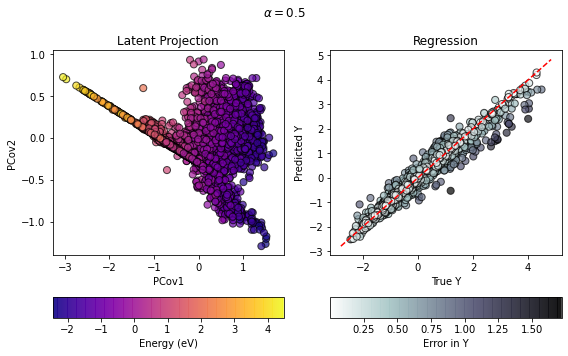

In [30]:
mixing = 0.5
pcovr = PCovR(mixing=mixing,
              n_components=2 )
pcovr.fit(X,Y)
T = pcovr.transform(X)
yp = pcovr.predict(X)

fig, ((axT, axy), (caxT, caxy)) = plt.subplots(
    2, 2, figsize=(8, 5), gridspec_kw=dict(height_ratios=(1, 0.1))
)

scatT = axT.scatter(T[:, 0], T[:, 1], s=50, alpha=0.7, c=Y, cmap='plasma', edgecolor="k")
axT.set_xlabel("PCov1")
axT.set_ylabel("PCov2")
axT.set_title("Latent Projection")
fig.colorbar(scatT, cax=caxT, label="Energy (eV)", orientation="horizontal")

scaty = axy.scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
fig.suptitle(r"$\alpha=$" + str(mixing))

axy.set_xlabel(r"True Y")
axy.set_ylabel(r"Predicted Y")
axy.set_title("Regression")
fig.colorbar(scaty, cax=caxy, label="Error in Y", orientation="horizontal")

fig.tight_layout()